In [2]:
libs <- c(
    'RColorBrewer',
    'ggplot2',
    'xgboost',
    'glmnet',
    'dplyr',
    'tidyr',
    'pROC',
    'ROCR',
    'stringr',
    'caret',
    'caTools'
)

for (lib in libs) {
        if (!require(lib, character.only = TRUE, quietly = TRUE)) {
            install.packages(lib, repos='http://cran.us.r-project.org')
        }
}

(.packages())

source("my_R_functions/utility_functions.R")
source("my_R_functions/stat_functions.R")
source("my_R_functions/plot_functions.R")
source("~/git-repos/BDDS/trenadb/src/utils.R")
source("~/git-repos/BDDS/footprints/testdb/src/dbFunctions.R")

[1] "RUnit"         "GenomicRanges" "GenomeInfoDb"  "IRanges"      
 [5] "S4Vectors"     "stats4"        "BiocGenerics"  "parallel"     
 [9] "RPostgreSQL"   "DBI"           "caTools"       "caret"        
[13] "lattice"       "stringr"       "ROCR"          "gplots"       
[17] "pROC"          "tidyr"         "dplyr"         "glmnet"       
[21] "foreach"       "Matrix"        "xgboost"       "ggplot2"      
[25] "RColorBrewer"  "stats"         "graphics"      "grDevices"    
[29] "utils"         "datasets"      "methods"       "base"

In [28]:
load("Rdata_files/motif_class_pairs.Rdata")
load("Rdata_files/Tfmotifmap.Rdata")

In [9]:
load("/local/rory/all.TF.df.fimo.hint.well.annotated.9.Rdata")

In [10]:
colnames(all.TF.df.fimo.hint.well.annotated) <- make.names(colnames(all.TF.df.fimo.hint.well.annotated), unique=TRUE)

all.TF.df.fimo.hint.well.annotated %>%
    filter(h_count > 0 | w_count > 0 | cs_hit > 0) ->
    df_only_footprint_hits

In [32]:
df_only_footprint_hits %>%
    select(chrom,
           cs_hit,
           motifname,
           motifscore,
           h_count,
           h_max_score,
           w_count,
           w_min_score,
           gc_content,
           asinh_tss_dist) ->
    df_cols_selected

head(df_cols_selected)

chrom,cs_hit,motifname,motifscore,h_count,h_max_score,w_count,w_min_score,gc_content,asinh_tss_dist
1,1,MA0150.2,13.21210,4,309,2,-33.02390,0.6119403,10.29384
1,1,MA0591.1,11.65790,3,64,1,-13.50040,0.6169154,10.29377
1,1,MA0492.1,9.72340,2,95,1,-3.23398,0.3283582,11.47418
1,1,MA0834.1,7.65714,2,61,5,-32.19650,0.5174129,10.90485
1,1,MA0492.1,13.72340,1,19,3,-10.10920,0.4875622,10.90018
1,1,MA0492.1,13.72340,5,277,2,-8.62394,0.5024876,10.90143


In [33]:
df_cols_selected %>%
    filter(chrom %in% c("2","4")) %>%
    select(-chrom) ->
    val_df

df_cols_selected %>%
    filter(chrom %in% c("1","3","5")) %>%
    select(-chrom) ->
    test_df

df_cols_selected %>%
    filter(!(chrom %in% c("1","2","3","4","5"))) %>%
    select(-chrom) ->
    train_df

remove(all.TF.df.fimo.hint.well.annotated, df_only_footprint_hits)

In [34]:
head(train_df)

cs_hit,motifname,motifscore,h_count,h_max_score,w_count,w_min_score,gc_content,asinh_tss_dist
1,MA0491.1,10.87230,2,8,1,-7.57656,0.3980100,12.51923
1,MA0491.1,9.53191,1,22,0,0.00000,0.3830846,12.51897
1,MA0150.2,17.87880,2,83,3,-12.93590,0.4129353,12.18085
1,MA0591.1,7.71053,2,83,3,-12.93590,0.4129353,12.18084
1,MA0591.1,9.50000,1,45,2,-6.16800,0.4577114,12.00326
1,MA0491.1,9.48936,2,40,1,-8.12638,0.5124378,12.00211


In [88]:
all_stats_df <- data.frame()

for (TF in names(TFs.to.motifs)) {
    
    # get motifs matching this TF
    this_tfs_motifs <- TFs.to.motifs[[TF]]
    
    # filter down to only relevant motifs
    train_df %>%
        filter(motifname %in% this_tfs_motifs) ->
        this_tf_train_df
    test_df %>%
        filter(motifname %in% this_tfs_motifs) ->
        this_tf_test_df
    
    # make training and testing data sets
    X_train_this_tf <- as.matrix(select(this_tf_train_df,-one_of("cs_hit", "motifname")))
    y_train_this_tf <- this_tf_train_df$cs_hit
    X_test_this_tf <- as.matrix(select(this_tf_test_df,-one_of("cs_hit", "motifname")))
    y_test_this_tf <- this_tf_test_df$cs_hit
    
    # set parameters for gbdt
    param <- list("objective" = "binary:logistic",
          "max.depth" = 5,
          "eta" = 0.01,
          "eval.metric" = "auc"
          )
    
    # train gbdt
    gbdt_tf <- xgboost(
        params = param,
        data = X_train_this_tf,
        label = y_train_this_tf,
        nround = 100,
        verbose = FALSE,
        missing = NA
    )
    gbdt_tf$Model.Name <- TF
    
    
    # gather statistics for model on this TF
    this_tf_pred_df <- make.pred.df.from.model(gbdt_tf, X_test_this_tf, y_test_this_tf)
    colnames(this_tf_pred_df)[1] <- "ChIPseq.bound"
    this_tf_stat_df <- make.stats.df.from.preds(this_tf_pred_df)
    this_tf_stat_df$Train.Samples <- length(y_train_this_tf)
    this_tf_stat_df$Test.Samples <- length(y_test_this_tf)
    
    # save stats
    all_stats_df <- rbind(all_stats_df, this_tf_stat_df)

}

In [98]:
str(all_stats_df)

'data.frame':	5555 obs. of  10 variables:
 $ threshold    : num  0 0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 ...
 $ sensitivity  : num  1 1 1 1 1 1 1 1 1 1 ...
 $ specificity  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ ppv          : num  0.601 0.601 0.601 0.601 0.601 ...
 $ npv          : num  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...
 $ accuracy     : num  0.601 0.601 0.601 0.601 0.601 ...
 $ MattCC       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Model.Name   : chr  "BHLHE40" "BHLHE40" "BHLHE40" "BHLHE40" ...
 $ Train.Samples: int  6703 6703 6703 6703 6703 6703 6703 6703 6703 6703 ...
 $ Test.Samples : int  1701 1701 1701 1701 1701 1701 1701 1701 1701 1701 ...


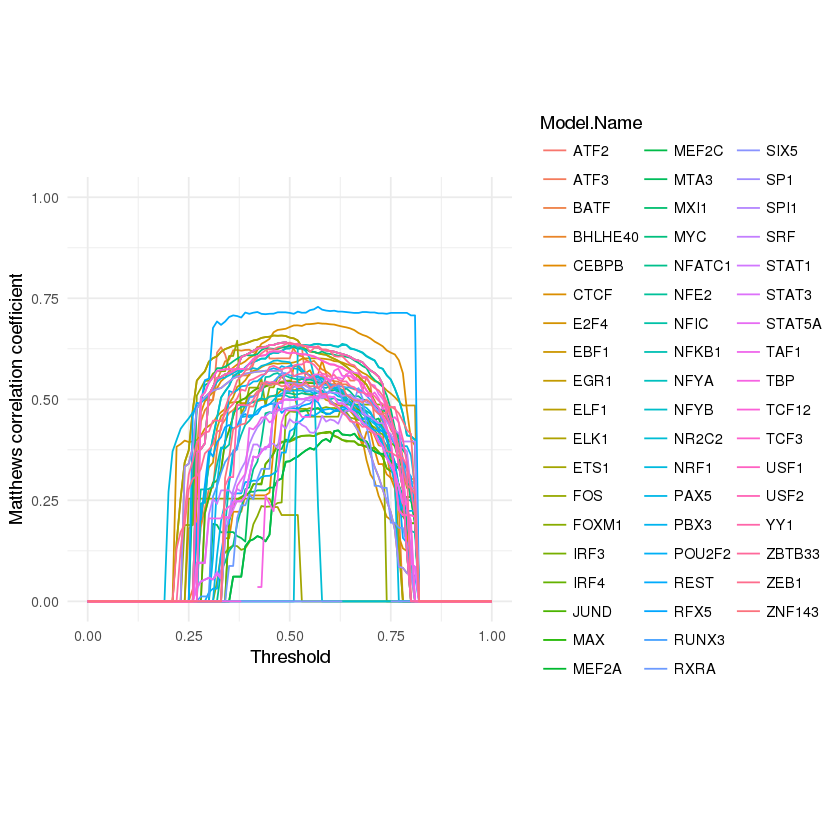

In [90]:
plot.mattcc.curve(all_stats_df) + theme_minimal()

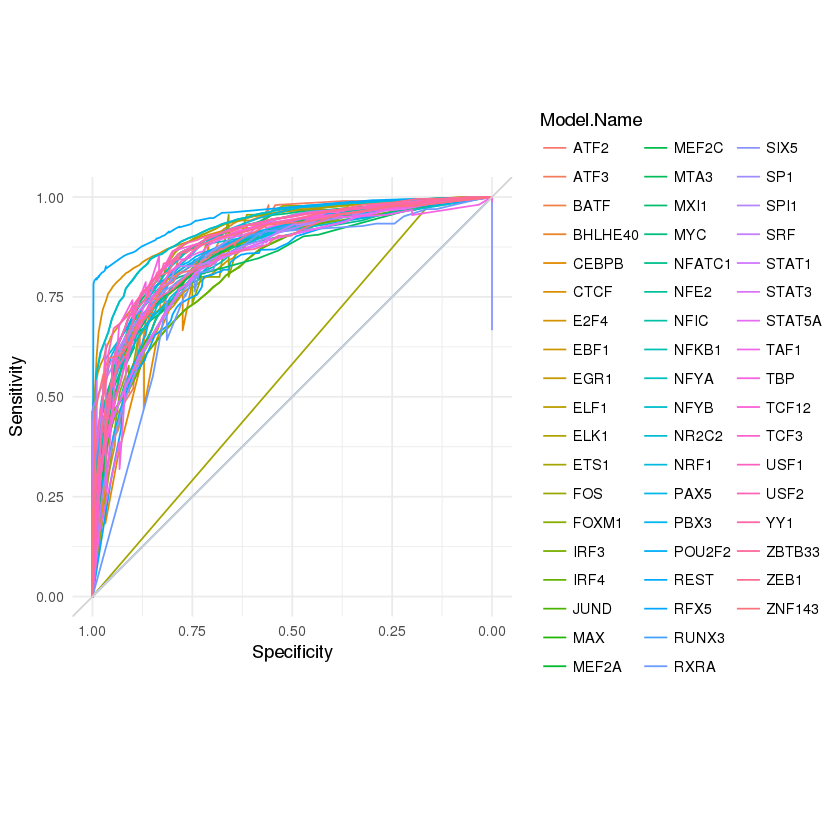

In [91]:
plot.roc.curve(all_stats_df) + theme_minimal()

Warning message:
“Removed 1171 rows containing missing values (geom_path).”

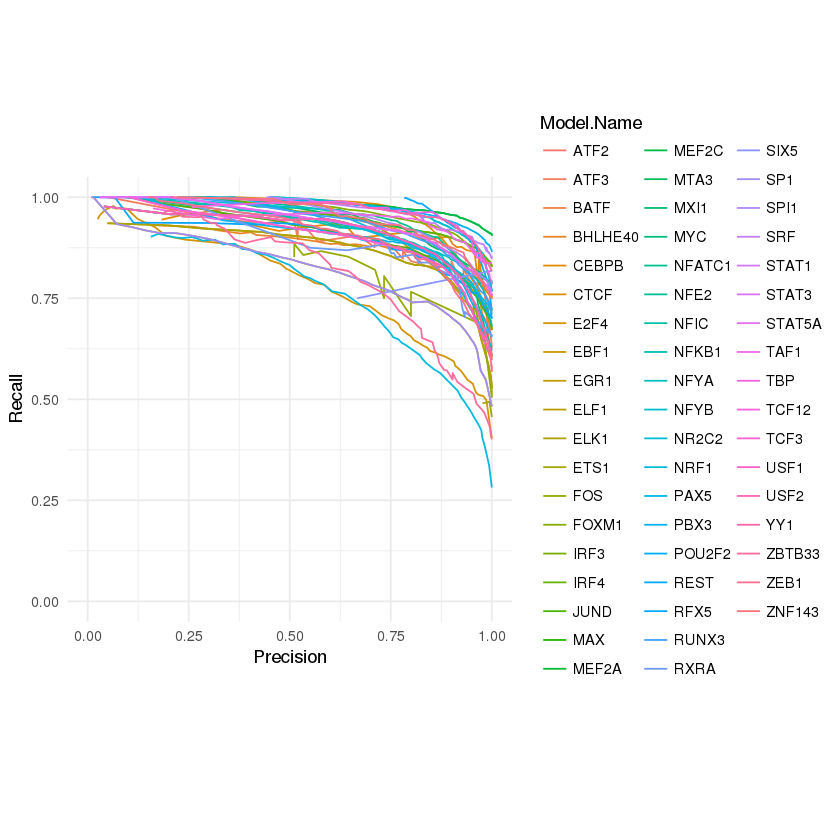

In [92]:
plot.precrecall.curve(all_stats_df) + theme_minimal()

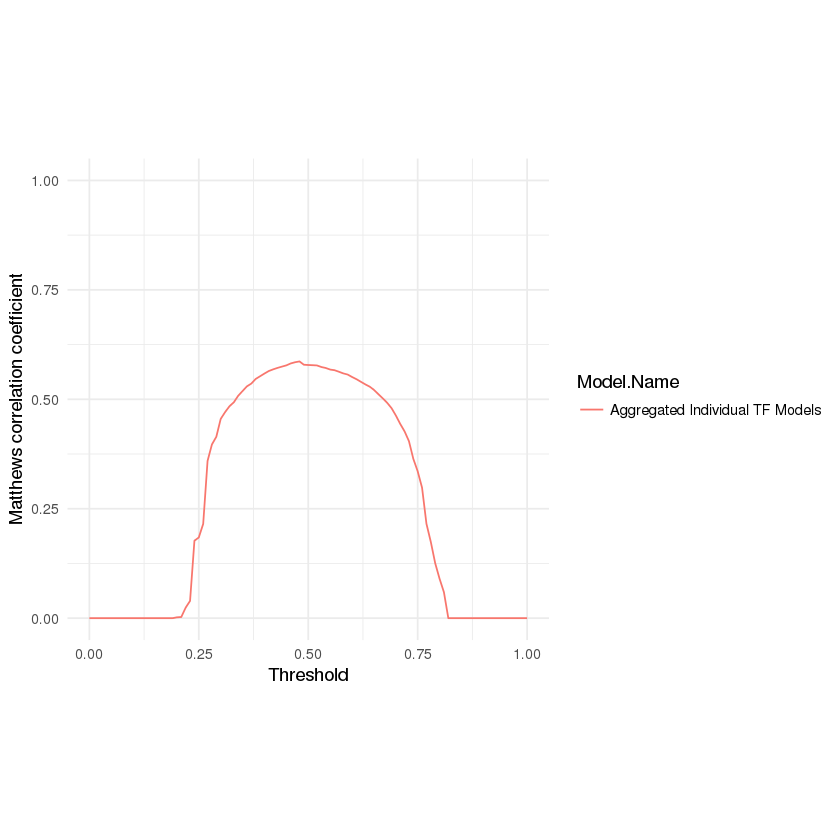

In [161]:
all_stats_df %>%
    select(-Model.Name) %>%
    group_by(threshold) %>%
    summarise_each(funs(weighted.mean(., Test.Samples)), -one_of("Test.Samples","Train.Samples")) %>%
    mutate(Model.Name="Aggregated Individual TF Models") %>%
    plot.mattcc.curve

In [259]:
all_stats_motif_df <- data.frame()

motifs <- unique(train_df$motifname) %>% intersect(unique(test_df$motifname))
for (motif in motifs) {
    
    # filter down to only relevant motifs
    train_df %>%
        filter(motifname == motif) ->
        this_motif_train_df
    test_df %>%
        filter(motifname == motif) ->
        this_motif_test_df
    
    # make training and testing data sets
    X_train_this_motif <- as.matrix(select(this_motif_train_df,-one_of("cs_hit", "motifname")))
    y_train_this_motif <- this_motif_train_df$cs_hit
    X_test_this_motif <- as.matrix(select(this_motif_test_df,-one_of("cs_hit", "motifname")))
    y_test_this_motif <- this_motif_test_df$cs_hit
    
    # set parameters for gbdt
    param <- list("objective" = "binary:logistic",
          "max.depth" = 5,
          "eta" = 0.01,
          "eval.metric" = "auc"
          )
    
    # train gbdt
    gbdt_motif <- xgboost(
        params = param,
        data = X_train_this_motif,
        label = y_train_this_motif,
        nround = 100,
        verbose = FALSE,
        missing = NA
    )
    gbdt_motif$Model.Name <- motif
    
    
    # gather statistics for model on this motif
    this_motif_pred_df <- make.pred.df.from.model(gbdt_motif, X_test_this_motif, y_test_this_motif)
    colnames(this_motif_pred_df)[1] <- "ChIPseq.bound"
    this_motif_stat_df <- make.stats.df.from.preds(this_motif_pred_df)
    this_motif_stat_df$Train.Samples <- length(y_train_this_motif)
    this_motif_stat_df$Test.Samples <- length(y_test_this_motif)
    
    # save stats
    all_stats_motif_df <- rbind(all_stats_motif_df, this_motif_stat_df)

}

In [269]:
load(file="per_TF_output/all_together_tree_stats.Rdata")
medium_stat_df$Model.Name <- "All together Trees with Classes"

In [270]:
all_stats_motif_df %>%
    select(-Model.Name) %>%
    group_by(threshold) %>%
    summarise_each(funs(weighted.mean(., Test.Samples)), -one_of("Test.Samples","Train.Samples")) %>%
    mutate(Model.Name="Aggregated Individual Motif Models") ->
    aggreagate_stats_motif_df

all_stats_df %>%
    select(-Model.Name) %>%
    group_by(threshold) %>%
    summarise_each(funs(weighted.mean(., Test.Samples)), -one_of("Test.Samples","Train.Samples")) %>%
    mutate(Model.Name="Aggregated Individual TF Models") ->
    aggreagate_stats_TF_df

compare_methods_df <- rbind(aggreagate_stats_motif_df, aggreagate_stats_TF_df, medium_stat_df)

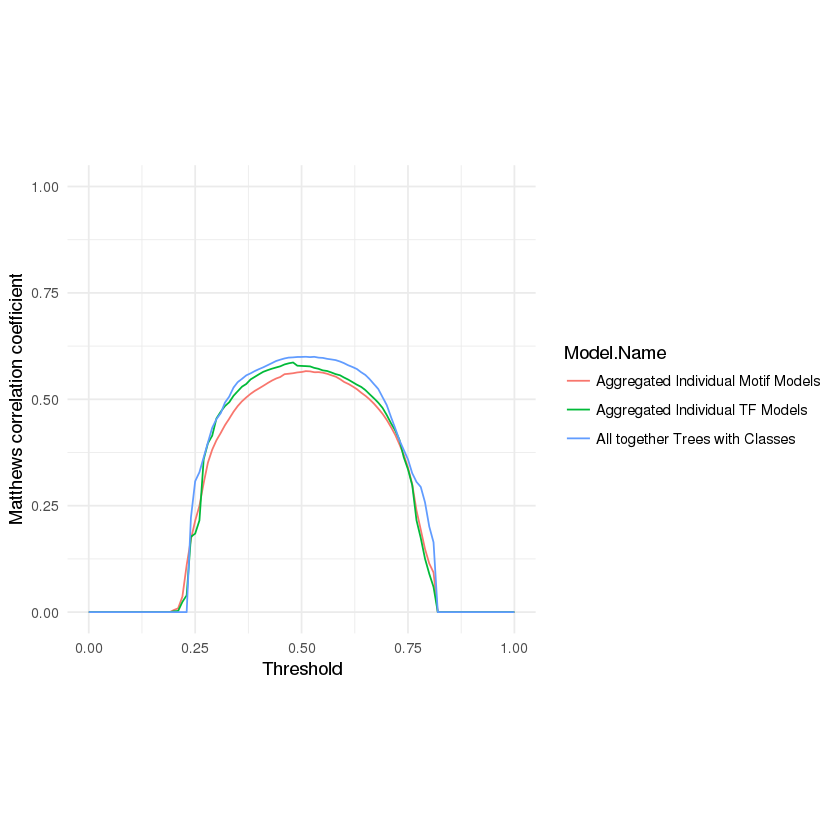

In [271]:
plot.mattcc.curve(compare_methods_df)

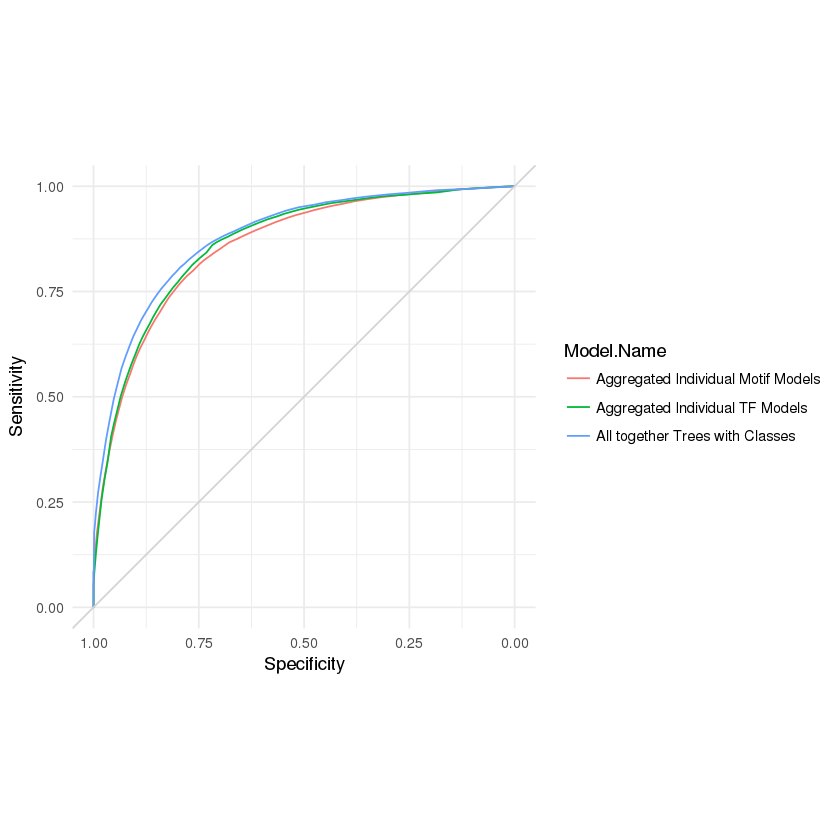

In [272]:
plot.roc.curve(compare_methods_df)

Warning message:
“Removed 67 rows containing missing values (geom_path).”

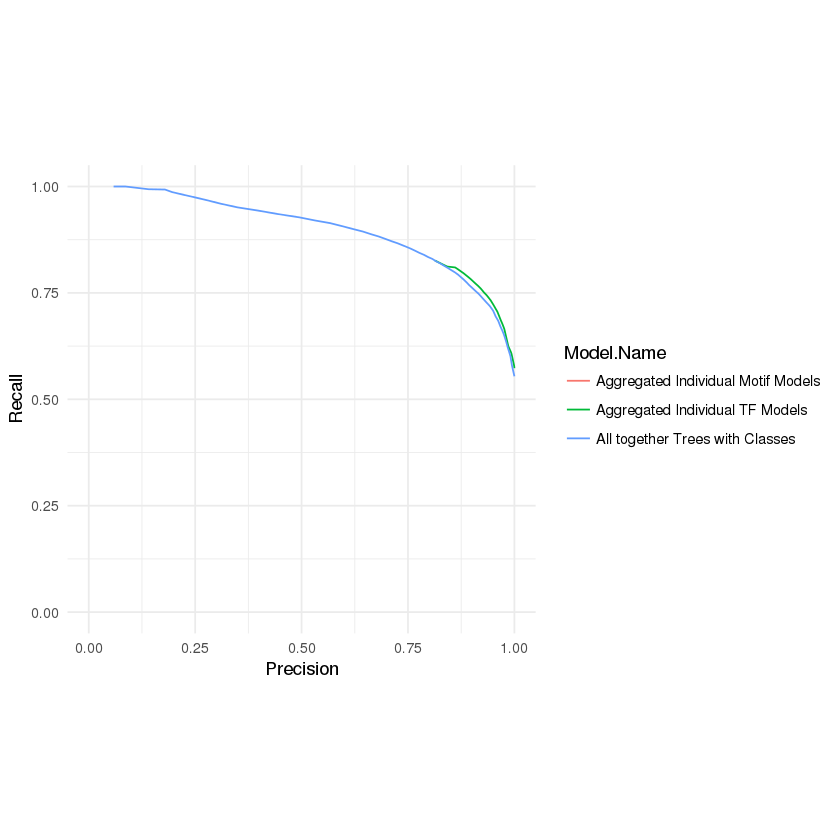

In [273]:
plot.precrecall.curve(compare_methods_df)